In [14]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

sys.path.append(os.path.abspath("../src"))  

my_analysis_path = '/home/gus/Documents/REPOS/tmt-analysis/data/hand_analysis/2025-05-16_15-31-02/metrics.csv'
metadata_path = '../data/metadata/metadata.csv'

df = pd.read_csv(my_analysis_path)

In [15]:
df['is_valid'].value_counts(dropna=False)

is_valid
True     1879
False     101
Name: count, dtype: int64

In [16]:
df.groupby(['subject_id', 'trial_type'])['is_valid'].sum().reset_index()

,subject_id,trial_type,is_valid
0,1,PART_A,10
1,1,PART_B,10
2,2,PART_A,10
3,2,PART_B,9
4,3,PART_A,10
...,...,...,...
193,97,PART_B,10
194,98,PART_A,8
195,98,PART_B,9
196,99,PART_A,10


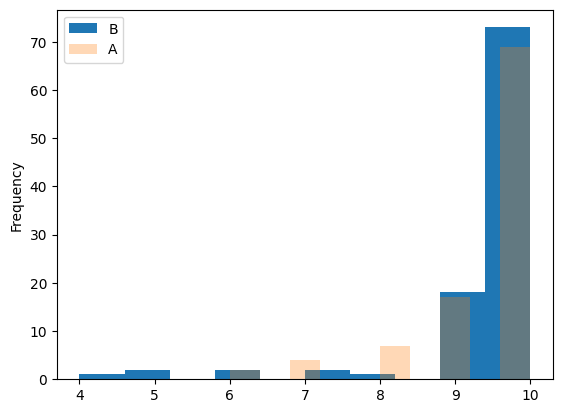

In [17]:
df_grouped = df.groupby(['subject_id', 'trial_type'])['is_valid'].sum().reset_index()
df_grouped[df_grouped['trial_type'] == 'PART_B']['is_valid'].plot(kind="hist")
df_grouped[df_grouped['trial_type'] == 'PART_A']['is_valid'].plot(kind="hist", alpha=0.3)
plt.legend(['B', 'A'])
df_grouped

# Pivot to have PART_A and PART_B sums in separate columns
df_pivot = df_grouped.pivot(index='subject_id', columns='trial_type', values='is_valid').reset_index()
df_pivot.columns = ['subject_id', 'is_valid_sum_A', 'is_valid_sum_B']

df = df.merge(df_pivot, on='subject_id')
df['is_valid_sum_A'] = (df['is_valid_sum_A'] / 10) * 100
df['is_valid_sum_B'] = (df['is_valid_sum_B'] / 10) * 100


In [81]:
def clean_metadata(path_to_metadata):
    df = (
    (
        pd.read_csv(path_to_metadata)
        .rename(
            columns={
                "Anteojos o lentes de contacto": "glasses",
                "Años de escolaridad": "years_of_education",
                "MMSE / 30": "MMSE",
                "Reloj / 3": "clock_drawing_test",
                "Nro de participante": "suj",
                "Género": "sex",
                "Edad": "age",
                "Grupo": "group",
                "TMT A papel PB": "tmt_a_raw",
                "TMT B papel PB": "tmt_b_raw",
                "Digit Symbol pb": "digit_symbol_raw",
                "Span directo pb": "forward_digit_span_raw",
                "span inverso pb": "backward_digit_span_raw",
                "reloj": "clock_drawing_test",
                'TMT A (papel) Z': 'tmt_a_z',
                'TMT B (papel) Z': 'tmt_b_z',
                'Digit - symbol Z': 'digit_symbol_z',
                'Span directo Z': 'forward_digit_span_z',
                'Span inverso z': 'backward_digit_span_z'
            }
        )
        .replace("Caso ?", "Caso")
    )
    .drop([0, 1])
    .reset_index(drop=True) 
    )  # 0 and 1 are summary
    print(df)

    df.columns = [x.lower() for x in df.columns]
    print(df.columns)
    df = df.replace(",", ".", regex=True)
    df["sex"] = df["sex"].replace({"F": 1, "M": 0}).astype("Int64")
    df["group"] = df["group"].str.lower()
    df = df.replace("caso", "mci")
    df = df.replace("Suspendido", 300).replace("No logra", 300)  # 300 seconds it is the max time based on the literature
    df['digit_symbol_raw'] = df['digit_symbol_raw'].replace('no se lo administraron', np.nan).astype(float)
    df['digit_symbol_z'] = df['digit_symbol_z'].replace('pendiente', np.nan).astype(float)
    df = df.astype({"tmt_a_raw": float, "tmt_b_raw": float})
    df["suj"] = df["suj"].astype(int)
    return df

In [82]:
df_metadata_complete = pd.read_csv(metadata_path)
df_metadata_complete.columns
# [col for col in df_metadata_complete.columns if col.endswith(('z', 'Z'))]


Index(['Nro de participante', 'Grupo', 'Clasificación de caso',
       'Comentario (tipo de caso o criterio de exclusión)', 'ID participante',
       'Fecha', 'Hora', 'Neuropsicol.', 'EyeTracker', 'Género', 'Edad',
       'Anteojos o lentes de contacto', 'Observaciones', 'MMSE / 30',
       'MMSE Fallas', 'TMT A papel PB', 'TMT A (papel) Z', 'TMT B papel PB',
       'TMT B papel errores', 'TMT B (papel) Z', 'Digit Symbol pb',
       'Digit - symbol Z', 'Span directo pb', 'Span directo Z',
       'span inverso pb', 'Span inverso z', 'Reloj / 3',
       'Años de escolaridad'],
      dtype='object')

In [83]:
df_metadata = clean_metadata(metadata_path)
df_metadata


    suj    group Clasificación de caso  \
0     1  Control                   NaN   
1     2  Control                   NaN   
2     3     Caso    DCL MD no amnesico   
3     4     Caso    DCL MD no amnesico   
4     5     Caso    DCL MD no amnesico   
..  ...      ...                   ...   
95   97     caso       DCL no amnesico   
96   98     caso       DCL no amnesico   
97   99     caso       DCL no amnesico   
98  100  control                   NaN   
99  101  control                   NaN   

   Comentario (tipo de caso o criterio de exclusión) ID participante  \
0                                                  *          946462   
1                                                  *         2684844   
2                                                NaN            6305   
3                                                NaN         2060316   
4                                                NaN            4744   
..                                               ...           

,suj,group,clasificación de caso,comentario (tipo de caso o criterio de exclusión),id participante,fecha,hora,neuropsicol.,eyetracker,sex,age,glasses,observaciones,mmse,mmse fallas,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt b papel errores,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test,years_of_education
0,1,control,NaN,*,946462,22/1/2024,14:30,Betsabé,Gus,1,52,-,No trajo los lentes para ver de cerca,30.0,--,32.00,0.37,47.00,NaN,1.36,63.0,0.00,6.0,-0.17,4.0,-0.60,2.0,18.0
1,2,control,NaN,*,2684844,22/1/2024,15:00,Betsabé,Gus,0,78,Anteojos,NaN,28.0,-2 recuerdo,47.00,0.36,82.00,NaN,0.85,36.0,0.67,6.0,0.07,5.0,0.5,3.0,16.0
2,3,mci,DCL MD no amnesico,NaN,6305,22/1/2024,15:30,Laura,Gus,1,68,Anteojos,NaN,28.0,-2 atención,65.00,-0.38,107.00,NaN,0.40,45.0,0.33,5.0,0.64,4.0,0.21,3.0,12.0
3,4,mci,DCL MD no amnesico,NaN,2060316,22/1/2024,16:00,Laura,Gus,1,80,Anteojos,NaN,28.0,-1 atención. -1 recuerdo,55.00,0.03,109.00,NaN,0.36,38.0,1.33,5.0,-0.64,4.0,-0.21,3.0,15.0
4,5,mci,DCL MD no amnesico,NaN,4744,22/1/2024,16:30,Betsabé,Gus,1,87,Anteojos,NaN,25.0,-2 OT. -1 At. -1 rec. -1VC,63.00,-0.29,180.09,(2 errores),-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,mci,DCL no amnesico,NaN,2302423,7/10/2024,13hs,Betsabe,Alejandro,1,75,anteojos,NaN,27.0,1 atenc. 2 recuerdo,38.90,0.69,93.70,2 errores,0.64,28.0,0.00,7.0,1.58,4.0,0.80,3.0,12.0
96,98,mci,DCL no amnesico,NaN,3104154,21/10/2024,13hs,Betsabe,Alejandro,1,70,anteojos,NaN,29.0,1 recuerdo,40.36,-0.63,140.00,4 errores,0.19,46.0,1.00,5.0,-0.08,4.0,0.80,3.0,15.0
97,99,mci,DCL no amnesico,NaN,2486596,21/10/2024,1:15:00 p.m.,Betsabe,Alejandro,1,71,NaN,NaN,29.0,1 recuerdo,51.80,0.16,78.30,NaN,0.92,42.0,0.67,6.0,0.75,6.0,2.80,3.0,18.0
98,100,control,NaN,NaN,22945,11/11/2024,13hs,Betsabe,Alejandro,0,76,anteojos,NaN,29.0,1 VC,50.42,0.22,69.40,-,1.08,40.0,0.67,8.0,2.42,5.0,1.80,3.0,18.0


In [84]:
df_metadata

,suj,group,clasificación de caso,comentario (tipo de caso o criterio de exclusión),id participante,fecha,hora,neuropsicol.,eyetracker,sex,age,glasses,observaciones,mmse,mmse fallas,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt b papel errores,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test,years_of_education
0,1,control,NaN,*,946462,22/1/2024,14:30,Betsabé,Gus,1,52,-,No trajo los lentes para ver de cerca,30.0,--,32.00,0.37,47.00,NaN,1.36,63.0,0.00,6.0,-0.17,4.0,-0.60,2.0,18.0
1,2,control,NaN,*,2684844,22/1/2024,15:00,Betsabé,Gus,0,78,Anteojos,NaN,28.0,-2 recuerdo,47.00,0.36,82.00,NaN,0.85,36.0,0.67,6.0,0.07,5.0,0.5,3.0,16.0
2,3,mci,DCL MD no amnesico,NaN,6305,22/1/2024,15:30,Laura,Gus,1,68,Anteojos,NaN,28.0,-2 atención,65.00,-0.38,107.00,NaN,0.40,45.0,0.33,5.0,0.64,4.0,0.21,3.0,12.0
3,4,mci,DCL MD no amnesico,NaN,2060316,22/1/2024,16:00,Laura,Gus,1,80,Anteojos,NaN,28.0,-1 atención. -1 recuerdo,55.00,0.03,109.00,NaN,0.36,38.0,1.33,5.0,-0.64,4.0,-0.21,3.0,15.0
4,5,mci,DCL MD no amnesico,NaN,4744,22/1/2024,16:30,Betsabé,Gus,1,87,Anteojos,NaN,25.0,-2 OT. -1 At. -1 rec. -1VC,63.00,-0.29,180.09,(2 errores),-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,mci,DCL no amnesico,NaN,2302423,7/10/2024,13hs,Betsabe,Alejandro,1,75,anteojos,NaN,27.0,1 atenc. 2 recuerdo,38.90,0.69,93.70,2 errores,0.64,28.0,0.00,7.0,1.58,4.0,0.80,3.0,12.0
96,98,mci,DCL no amnesico,NaN,3104154,21/10/2024,13hs,Betsabe,Alejandro,1,70,anteojos,NaN,29.0,1 recuerdo,40.36,-0.63,140.00,4 errores,0.19,46.0,1.00,5.0,-0.08,4.0,0.80,3.0,15.0
97,99,mci,DCL no amnesico,NaN,2486596,21/10/2024,1:15:00 p.m.,Betsabe,Alejandro,1,71,NaN,NaN,29.0,1 recuerdo,51.80,0.16,78.30,NaN,0.92,42.0,0.67,6.0,0.75,6.0,2.80,3.0,18.0
98,100,control,NaN,NaN,22945,11/11/2024,13hs,Betsabe,Alejandro,0,76,anteojos,NaN,29.0,1 VC,50.42,0.22,69.40,-,1.08,40.0,0.67,8.0,2.42,5.0,1.80,3.0,18.0


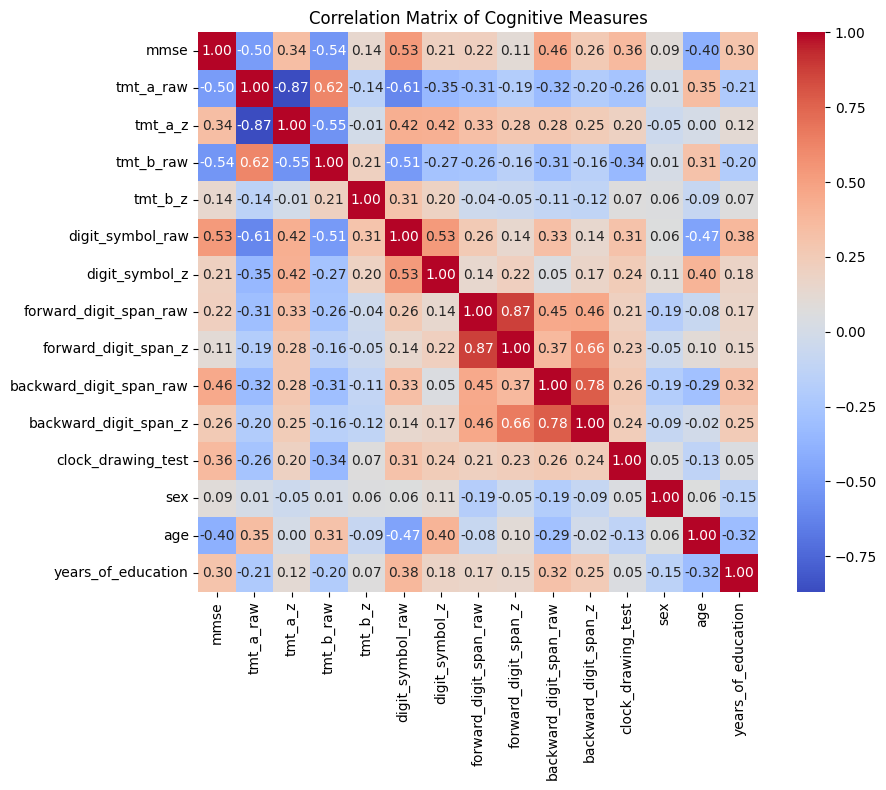

In [94]:
# Clean and convert appropriate columns to numeric
cognitive_columns = ['mmse','tmt_a_raw', 'tmt_a_z',
                    'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw',
                    'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
                    'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test',]

demographic_colums = ['sex', 'age','years_of_education']

group_column = ['group']

df_metadata_cognitive = df_metadata[['suj','group'] + demographic_colums + cognitive_columns].copy()

df_all = df.merge(df_metadata_cognitive, left_on='subject_id', right_on='suj').rename(columns={"sex_y": "sex", "age_y": "age", "group_y": "group"})
keep_cols = [i for i in df_all.columns if "_x" not in i]
df_all = df_all[keep_cols]

# Compute correlation matrix
corr_matrix = df_metadata[cognitive_columns + demographic_colums].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Cognitive Measures")
plt.tight_layout()
plt.show()

In [107]:
df = df_all.copy()

df_valid = df[df["is_valid"]]

valid_counts = df_valid.groupby(['subject_id', 'trial_type']).size().unstack(fill_value=0)

subjects_with_enough_valid_trials = valid_counts[
    (valid_counts.get('PART_A', 0) >= 2) & (valid_counts.get('PART_B', 0) >= 2)
].index

df_valid = df_valid[df_valid['subject_id'].isin(subjects_with_enough_valid_trials)]


digital_tmt_vars = [
    'speed_threshold', 'total_distance', 'rt',
       'correct_targets_touches', 'wrong_targets_touches', 'mean_speed',
       'std_speed', 'peak_speed', 'mean_acceleration', 'std_acceleration',
       'peak_acceleration', 'mean_abs_acceleration', 'std_abs_acceleration',
       'peak_abs_acceleration', 'mean_negative_acceleration',
       'std_negative_acceleration', 'peak_negative_acceleration',
       'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
       'travel_distance', 'search_distance', 'hesitation_avg_speed',
       'travel_avg_speed', 'search_avg_speed', 'state_transitions',
       'hesitation_ratio', 'total_hesitations', 'average_duration',
       'max_duration','zigzag_amplitude', 'distance_difference_from_ideal', 
       'area_difference_from_ideal',
]

non_digital_vars = ['mmse', 'tmt_a_raw',
                    'tmt_a_z', 'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw', 'digit_symbol_z',
                    'forward_digit_span_raw', 'forward_digit_span_z',
                    'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test']


df_digital_tmt = df_valid.pivot_table(index='subject_id', columns="trial_type", values=digital_tmt_vars)

df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]
df_digital_tmt

# df_other_tasks = df_valid.groupby("subject_id")[other_test_vars].mean()

# df_all_tasks = df_other_tasks.join(df_digital_tmt)

df_digital_tmt_with_target = df_digital_tmt.reset_index(names='suj').merge(df_metadata_cognitive[['suj'] + ['group']], on='suj').set_index('suj')
df_digital_tmt_with_target['group'] = df_digital_tmt_with_target['group'].str.replace('mci', '1').replace('control', '0').astype(int)

demographic_df = df_metadata_cognitive[['suj', 'sex', 'age', 'years_of_education','group']].set_index('suj').copy()
demographic_df['group'] = demographic_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)

non_digital_df = df_metadata_cognitive[['suj'] + non_digital_vars + ['group']].set_index('suj').copy()
non_digital_df['group'] = non_digital_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
non_digital_df

,mmse,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test,group
suj,,,,,,,,,,,,,
1,30.0,32.00,0.37,47.00,1.36,63.0,0.00,6.0,-0.17,4.0,-0.60,2.0,0
2,28.0,47.00,0.36,82.00,0.85,36.0,0.67,6.0,0.07,5.0,0.5,3.0,0
3,28.0,65.00,-0.38,107.00,0.40,45.0,0.33,5.0,0.64,4.0,0.21,3.0,1
4,28.0,55.00,0.03,109.00,0.36,38.0,1.33,5.0,-0.64,4.0,-0.21,3.0,1
5,25.0,63.00,-0.29,180.09,-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,27.0,38.90,0.69,93.70,0.64,28.0,0.00,7.0,1.58,4.0,0.80,3.0,1
98,29.0,40.36,-0.63,140.00,0.19,46.0,1.00,5.0,-0.08,4.0,0.80,3.0,1
99,29.0,51.80,0.16,78.30,0.92,42.0,0.67,6.0,0.75,6.0,2.80,3.0,1


dataset: non_digital_tests
Class distribution: {0: 45, 1: 55}

🧪 Nested CV for: RandomForestClassifier
Fitting 3 folds for each of 16 candidates, totalling 48 fits


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits


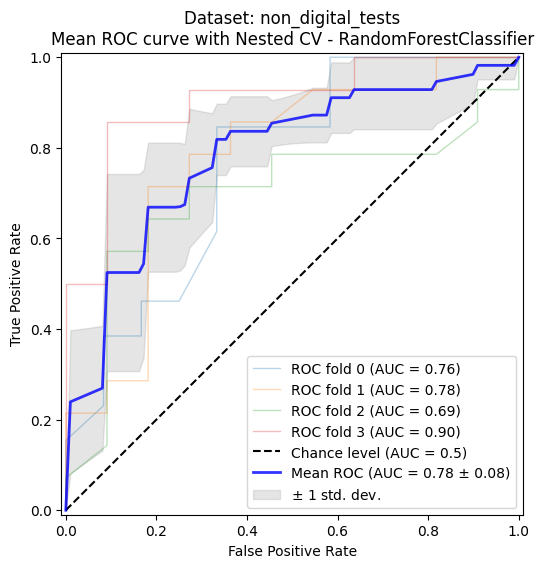

🔧 Best hyperparameters across folds for RandomForestClassifier:
  Fold 0: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
  Fold 1: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
  Fold 2: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
  Fold 3: {'classifier__max_depth': None, 'classifier__n_estimators': 700}

📊 Top selected features for RandomForestClassifier:
  mmse: selected in 2/4 folds
  tmt_a_raw: selected in 2/4 folds
  tmt_a_z: selected in 2/4 folds
  tmt_b_raw: selected in 2/4 folds
  tmt_b_z: selected in 2/4 folds
  digit_symbol_raw: selected in 2/4 folds
  digit_symbol_z: selected in 2/4 folds
  forward_digit_span_raw: selected in 2/4 folds
  backward_digit_span_raw: selected in 2/4 folds
  backward_digit_span_z: selected in 2/4 folds

🧪 Nested CV for: SVC
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalli

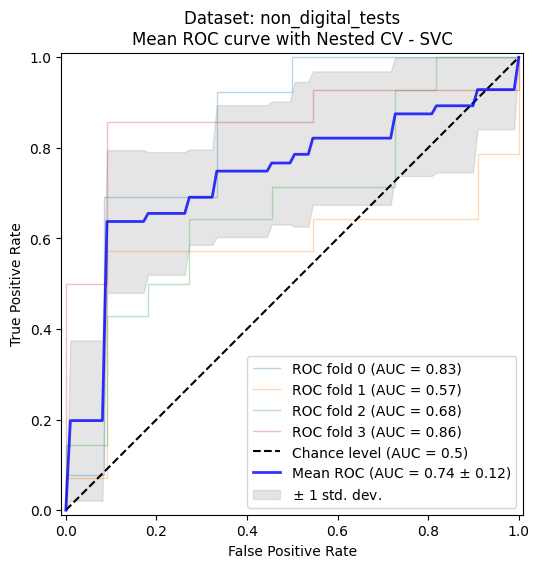

🔧 Best hyperparameters across folds for SVC:
  Fold 0: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
  Fold 1: {'classifier__C': 10, 'classifier__kernel': 'linear'}
  Fold 2: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
  Fold 3: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}

📊 Top selected features for SVC:
  mmse: selected in 2/4 folds
  tmt_a_raw: selected in 2/4 folds
  tmt_a_z: selected in 2/4 folds
  tmt_b_raw: selected in 2/4 folds
  tmt_b_z: selected in 2/4 folds
  digit_symbol_raw: selected in 2/4 folds
  digit_symbol_z: selected in 2/4 folds
  forward_digit_span_raw: selected in 2/4 folds
  backward_digit_span_raw: selected in 2/4 folds
  backward_digit_span_z: selected in 2/4 folds

🧪 Nested CV for: LogisticRegression
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits


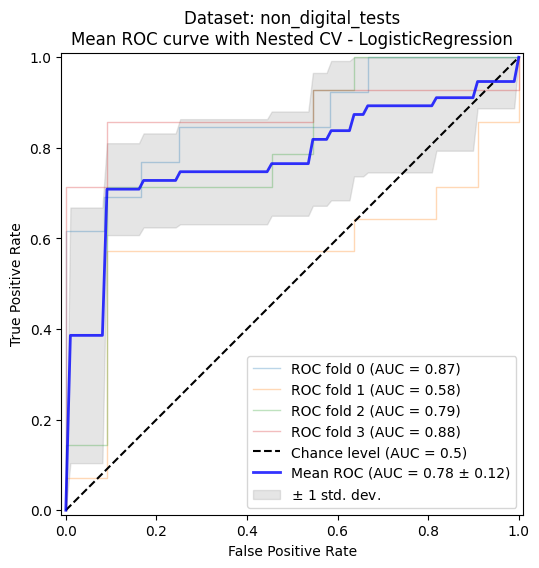

🔧 Best hyperparameters across folds for LogisticRegression:
  Fold 0: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
  Fold 1: {'classifier__C': 10, 'classifier__penalty': 'l2'}
  Fold 2: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
  Fold 3: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}

📊 Top selected features for LogisticRegression:
  mmse: selected in 2/4 folds
  tmt_a_raw: selected in 2/4 folds
  tmt_a_z: selected in 2/4 folds
  tmt_b_raw: selected in 2/4 folds
  tmt_b_z: selected in 2/4 folds
  digit_symbol_raw: selected in 2/4 folds
  digit_symbol_z: selected in 2/4 folds
  forward_digit_span_raw: selected in 2/4 folds
  backward_digit_span_raw: selected in 2/4 folds
  backward_digit_span_z: selected in 2/4 folds

🧪 Nested CV for: XGBClassifier
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates

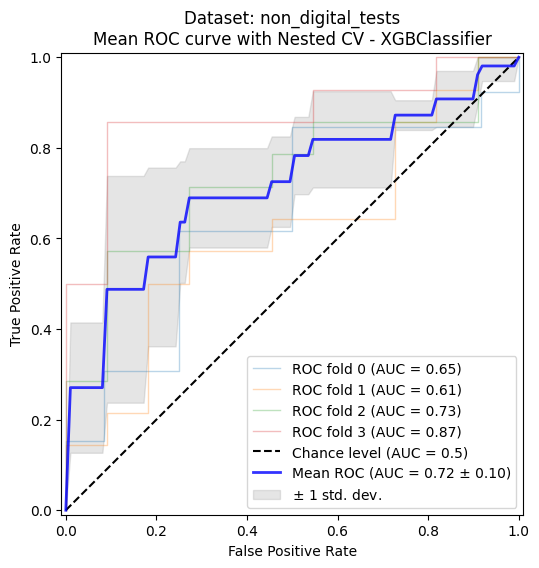

🔧 Best hyperparameters across folds for XGBClassifier:
  Fold 0: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
  Fold 1: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
  Fold 2: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
  Fold 3: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

📊 Top selected features for XGBClassifier:
  mmse: selected in 2/4 folds
  tmt_a_raw: selected in 2/4 folds
  tmt_a_z: selected in 2/4 folds
  tmt_b_raw: selected in 2/4 folds
  tmt_b_z: selected in 2/4 folds
  digit_symbol_raw: selected in 2/4 folds
  digit_symbol_z: selected in 2/4 folds
  forward_digit_span_raw: selected in 2/4 folds
  backward_digit_span_raw: selected in 2/4 folds
  backward_digit_span_z: selected in 2/4 folds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb


dataset = 'non_digital_tests'
importances_added = False  # Prevents printing for every fold
print('dataset:', dataset)

# Assuming df_digital_tmt_with_target is already defined
match dataset:
    case 'demographic':
        X = demographic_df.iloc[:, :-1].values
        y = demographic_df.iloc[:, -1].values
        feature_names = demographic_df.columns[:-1]
    case 'non_digital_tests':
        X = non_digital_df.iloc[:, :-1].values
        y = non_digital_df.iloc[:, -1].values
        feature_names = non_digital_df.columns[:-1]
    case 'digital_test':
        X = df_digital_tmt_with_target.iloc[:, :-1].values
        y = df_digital_tmt_with_target.iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.columns[:-1]
    case _:
        raise ValueError('please select a valid dataset [`demographic`, `non_digital_tests` or `digital_test`]')

n_importances = 10

# Print class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Define parameter grids
param_grids = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ['l2']
    },
    "XGBClassifier": {
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

# Define models to evaluate
models = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    LogisticRegression(max_iter=1000, random_state=42),
    xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
]

# Set up outer CV
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)

# Track results across models
model_results = {}

# Perform nested CV for each model
for model in models:
    model_name = model.__class__.__name__
    print(f"\n🧪 Nested CV for: {model_name}")
    
    # Results for this model
    tprs = []
    aucs = []
    best_params_list = []
    selected_features = []
    fig, ax = plt.subplots(figsize=(6, 6))
    
    feature_importance_counts = {name: 0 for name in feature_names}

    
    # Outer CV loop
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):

        # Reset feature importance counts for this model
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Define the pipeline - with RFE inside the pipeline
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1000), 
                                     n_features_to_select=n_importances)),
            ('classifier', model)
        ])
        
        # Set up grid search with inner CV
        param_grid = param_grids.get(model_name, {})
        grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,  # inner CV
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        
        # Train on the current fold
        grid.fit(X_train, y_train)
        
        # Store best parameters
        best_params_list.append(grid.best_params_)
        
        # Get the best model from GridSearchCV
        best_model = grid.best_estimator_
        
        # Track selected features
        feature_selector = best_model.named_steps['feature_selection']
        selected_mask = feature_selector.support_
        fold_selected_features = feature_names[selected_mask]
        selected_features.append(fold_selected_features)
        
        # Update feature importance counts
        for feature in fold_selected_features:
            feature_importance_counts[feature] += 1

        # Generate ROC curve
        viz = RocCurveDisplay.from_estimator(
            best_model,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == outer_cv.get_n_splits() - 1),
        )
        
        # Interpolate TPR for mean ROC
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    # Calculate mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot mean ROC
    ax.plot(mean_fpr, mean_tpr, color="b",
            label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
            lw=2, alpha=0.8)
    
    std_tpr = np.std(tprs, axis=0)
    ax.fill_between(mean_fpr,
                    np.maximum(mean_tpr - std_tpr, 0),
                    np.minimum(mean_tpr + std_tpr, 1),
                    color="grey", alpha=0.2,
                    label=r"$\pm$ 1 std. dev.")
    
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
           title=f"Dataset: {dataset}\nMean ROC curve with Nested CV - {model_name}")
    ax.legend(loc="lower right")
    plt.show()
    
    # Print best params from each fold
    print(f"🔧 Best hyperparameters across folds for {model_name}:")
    for i, params in enumerate(best_params_list):
        print(f"  Fold {i}: {params}")
    
    # Print most common selected features
    print(f"\n📊 Top selected features for {model_name}:")
    top_features = sorted(feature_importance_counts.items(), 
                         key=lambda x: x[1], reverse=True)[:10]
    for feature, count in top_features:
        if count > 0:  # Only show features that were selected at least once
            print(f"  {feature}: selected in {count}/{outer_cv.get_n_splits()} folds")
    
    # Store results for this model
    model_results[model_name] = {
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'selected_features': selected_features,
        'best_params': best_params_list
    }


In [128]:
model_results

{'RandomForestClassifier': {'mean_auc': 0.7848805235168871,
  'std_auc': 0.0752957849071428,
  'selected_features': [Index(['mmse', 'tmt_a_raw', 'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw',
          'digit_symbol_z', 'forward_digit_span_raw', 'backward_digit_span_raw',
          'backward_digit_span_z', 'clock_drawing_test'],
         dtype='object'),
   Index(['mmse', 'tmt_a_raw', 'tmt_a_z', 'tmt_b_raw', 'tmt_b_z',
          'digit_symbol_raw', 'forward_digit_span_raw', 'forward_digit_span_z',
          'backward_digit_span_raw', 'clock_drawing_test'],
         dtype='object'),
   Index(['mmse', 'tmt_a_z', 'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw',
          'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
          'backward_digit_span_raw', 'backward_digit_span_z'],
         dtype='object'),
   Index(['mmse', 'tmt_a_raw', 'tmt_a_z', 'tmt_b_raw', 'tmt_b_z',
          'digit_symbol_raw', 'digit_symbol_z', 'forward_digit_span_raw',
          'backward_digit_span_raw

In [126]:
feature_names

Index(['mmse', 'tmt_a_raw', 'tmt_a_z', 'tmt_b_raw', 'tmt_b_z',
       'digit_symbol_raw', 'digit_symbol_z', 'forward_digit_span_raw',
       'forward_digit_span_z', 'backward_digit_span_raw',
       'backward_digit_span_z', 'clock_drawing_test'],
      dtype='object')

{0: 43, 1: 55}

🧪 Nested CV for: RandomForestClassifier


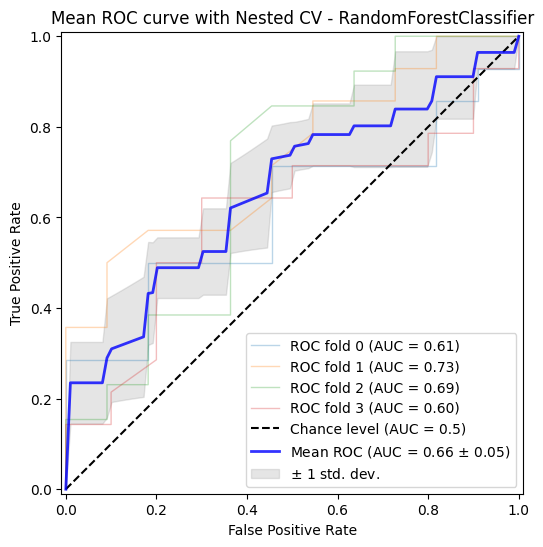

🔧 Best hyperparameters: {'classifier__max_depth': None, 'classifier__n_estimators': 500}


In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay, auc, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE

base_model = False

# Features & Target
if base_model:
    demographic_df = df_metadata_cognitive.set_index('suj').copy()
    df_metadata_cognitive['group'] = df_metadata_cognitive.pop('group')
    demographic_df['group'] = demographic_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
    feature_names = demographic_df.columns[:-1]

    X = demographic_df.iloc[:, :-1].values
    y = demographic_df.iloc[:, -1].values
    print(y)
else:
    X = df_digital_tmt_with_target.iloc[:, :-1].values
    y = df_digital_tmt_with_target.iloc[:, -1].values
    feature_names = df_digital_tmt_with_target.columns[:-1]

param_grids = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ['l2']
    },
    "XGBClassifier": {
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)

# Create a DataFrame to store all metrics for all models
all_metrics_df = pd.DataFrame(columns=[
    'model', 'fold', 'accuracy', 'balanced_accuracy', 'precision', 
    'recall', 'f1', 'auc', 'specificity'
])


unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


importances_added = False  # Prevents printing for every fold
n_importances = 15

rfe = RFE(estimator=LogisticRegression(), n_features_to_select=n_importances)

models = [
    RandomForestClassifier(random_state=420),
    # SVC(random_state=42, probability=True),
    # LogisticRegression(max_iter=1000, random_state=42),
    # xgb.XGBClassifier(tree_method="hist", use_label_encoder=False, eval_metric='logloss')
]

for model in models:
    

    model_name = model.__class__.__name__
    print(f"\n🧪 Nested CV for: {model_name}")

    steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('rfe', rfe),
        ('classifier', model)
    ]

    pipeline = Pipeline(steps)
    param_grid = param_grids.get(model_name, {})

    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=3,  # inner CV
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    fold_metrics = []
    tprs = []
    aucs = []

    fig, ax = plt.subplots(figsize=(6, 6))

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        grid.fit(X[train_idx], y[train_idx])

        best_model = grid.best_estimator_

        viz = RocCurveDisplay.from_estimator(
            best_model,
            X[test_idx],
            y[test_idx],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == outer_cv.get_n_splits() - 1),
        )

              # Get predicted probabilities and classes
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)
        
        # Calculate various metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        
        metrics = {
            'model': model_name,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': specificity
        }
        
        fold_metrics.append(metrics)
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr, color="b",
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
            lw=2, alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    ax.fill_between(mean_fpr,
                    np.maximum(mean_tpr - std_tpr, 0),
                    np.minimum(mean_tpr + std_tpr, 1),
                    color="grey", alpha=0.2,
                    label=r"$\pm$ 1 std. dev.")

    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
           title=f"Mean ROC curve with Nested CV - {model_name}")
    ax.legend(loc="lower right")
    plt.show()

    # Print best params (optional)
    print("🔧 Best hyperparameters:", grid.best_params_)


Class distribution: {0: 45, 1: 55}

🧪 Nested CV for: RandomForestClassifier
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits


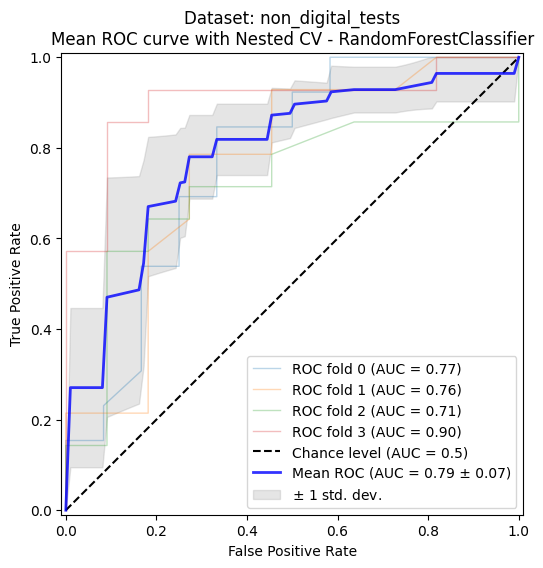

🔧 Best hyperparameters across folds for RandomForestClassifier:
  Fold 0: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
  Fold 1: {'classifier__max_depth': None, 'classifier__n_estimators': 1000}
  Fold 2: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
  Fold 3: {'classifier__max_depth': None, 'classifier__n_estimators': 700}


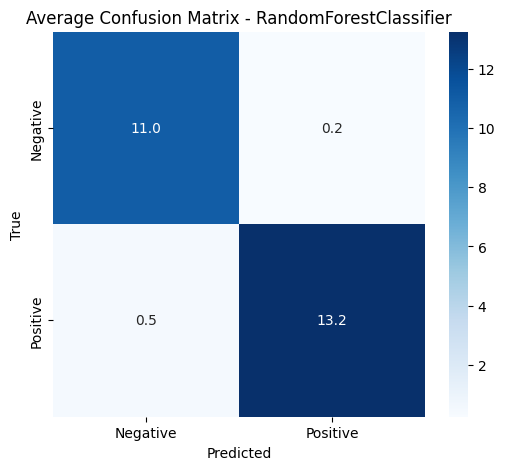

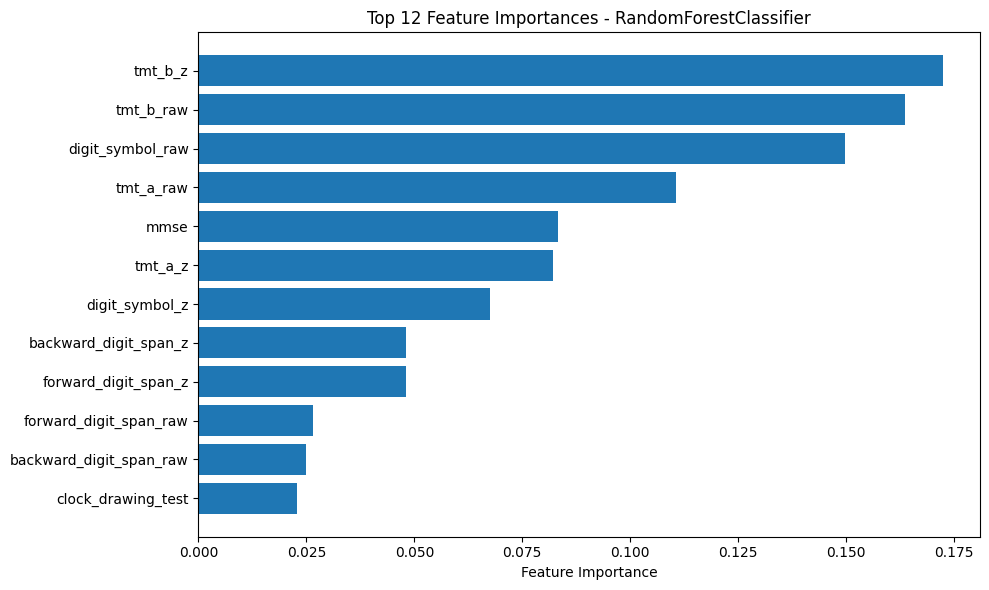


🧪 Nested CV for: SVC
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


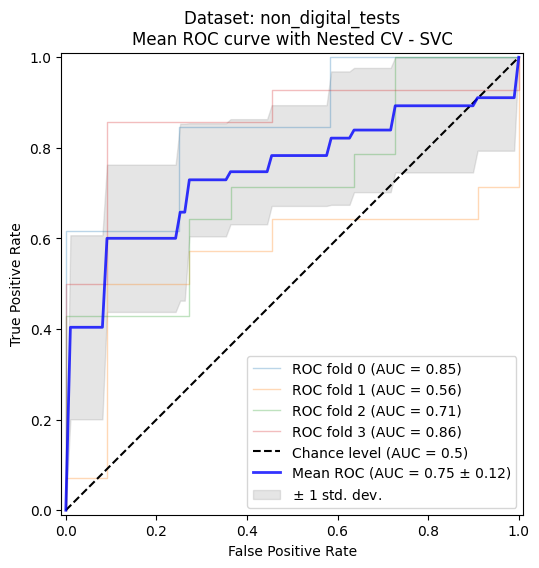

🔧 Best hyperparameters across folds for SVC:
  Fold 0: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
  Fold 1: {'classifier__C': 10, 'classifier__kernel': 'linear'}
  Fold 2: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
  Fold 3: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}


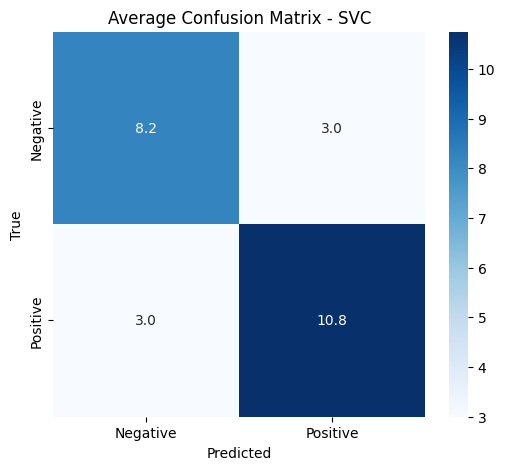


🧪 Nested CV for: LogisticRegression
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits


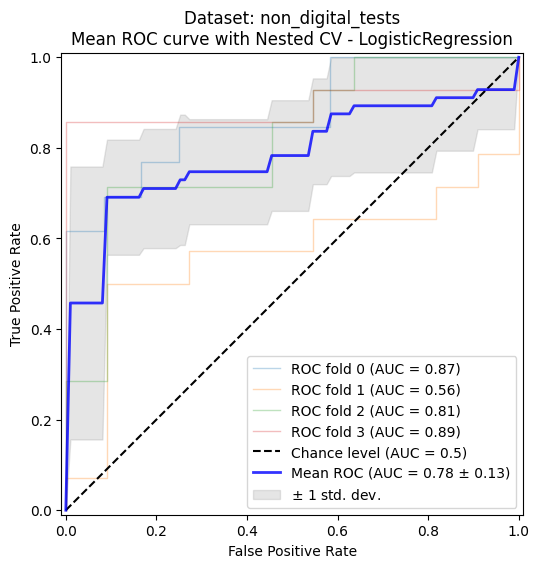

🔧 Best hyperparameters across folds for LogisticRegression:
  Fold 0: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
  Fold 1: {'classifier__C': 10, 'classifier__penalty': 'l2'}
  Fold 2: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
  Fold 3: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}


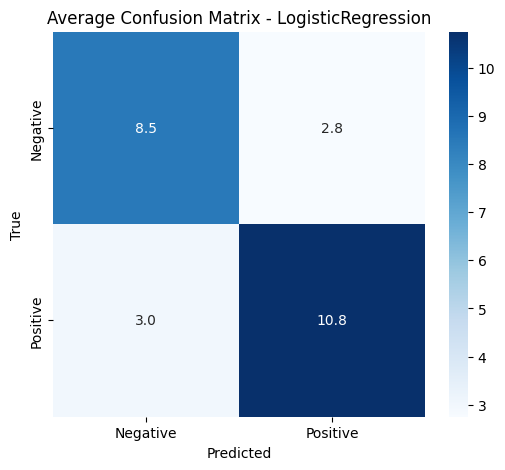


🧪 Nested CV for: XGBClassifier
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


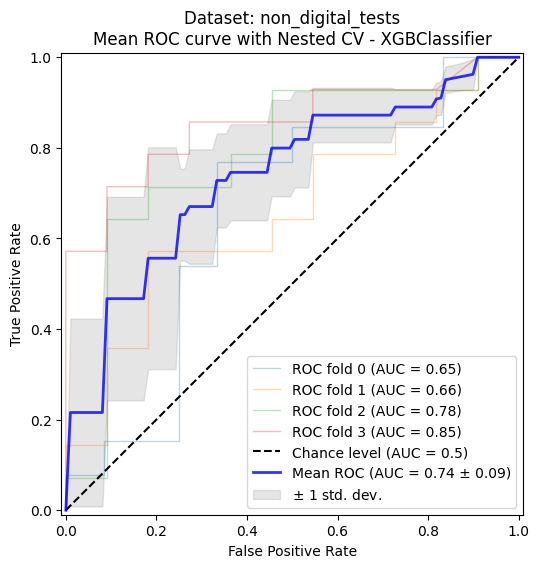

🔧 Best hyperparameters across folds for XGBClassifier:
  Fold 0: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
  Fold 1: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
  Fold 2: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
  Fold 3: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


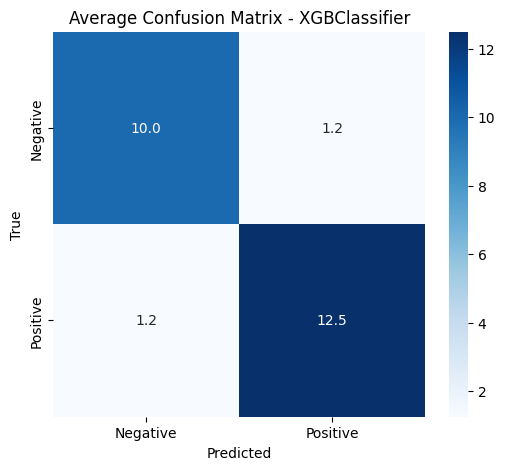


🏆 Model Performance Comparison:

ACCURACY:
  LogisticRegression: 0.730 ± 0.082
  RandomForestClassifier: 0.730 ± 0.115
  SVC: 0.730 ± 0.089
  XGBClassifier: 0.700 ± 0.052

BALANCED_ACCURACY:
  LogisticRegression: 0.740 ± 0.071
  RandomForestClassifier: 0.738 ± 0.108
  SVC: 0.735 ± 0.079
  XGBClassifier: 0.702 ± 0.052

PRECISION:
  LogisticRegression: 0.823 ± 0.091
  RandomForestClassifier: 0.795 ± 0.101
  SVC: 0.790 ± 0.077
  XGBClassifier: 0.744 ± 0.078

RECALL:
  LogisticRegression: 0.676 ± 0.211
  RandomForestClassifier: 0.694 ± 0.202
  SVC: 0.712 ± 0.199
  XGBClassifier: 0.712 ± 0.112

F1:
  LogisticRegression: 0.721 ± 0.120
  RandomForestClassifier: 0.728 ± 0.142
  SVC: 0.732 ± 0.122
  XGBClassifier: 0.721 ± 0.056

AUC:
  LogisticRegression: 0.785 ± 0.150
  RandomForestClassifier: 0.787 ± 0.081
  SVC: 0.747 ± 0.143
  XGBClassifier: 0.736 ± 0.098

SPECIFICITY:
  LogisticRegression: 0.805 ± 0.154
  RandomForestClassifier: 0.782 ± 0.139
  SVC: 0.758 ± 0.129
  XGBClassifier: 0.693 ± 

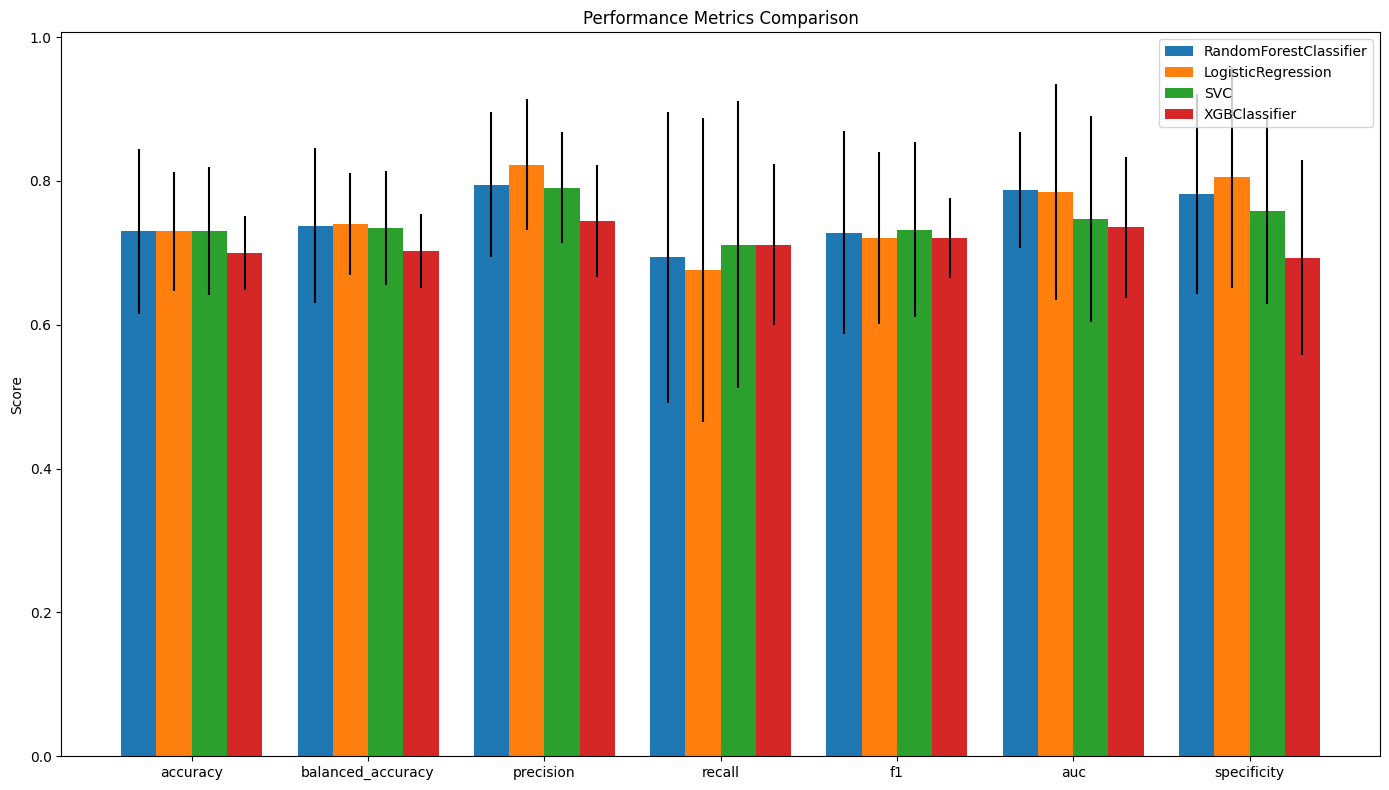

,accuracy,balanced_accuracy,precision,recall,f1,auc,specificity
model,,,,,,,
LogisticRegression,0.73,0.740374,0.822669,0.675824,0.720711,0.784507,0.804924
RandomForestClassifier,0.73,0.737939,0.794690,0.693681,0.728241,0.787265,0.782197
SVC,0.73,0.734557,0.790476,0.711538,0.732143,0.747232,0.757576
XGBClassifier,0.70,0.702360,0.744224,0.711538,0.720826,0.735702,0.693182


In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    RocCurveDisplay, auc, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb
import pandas as pd
import seaborn as sns

dataset = 'non_digital_tests'
importances_added = False  # Prevents printing for every fold
print('dataset:', dataset)

# Assuming df_digital_tmt_with_target is already defined
match dataset:
    case 'demographic':
        X = demographic_df.iloc[:, :-1].values
        y = demographic_df.iloc[:, -1].values
        feature_names = demographic_df.columns[:-1]
    case 'non_digital_tests':
        X = non_digital_df.iloc[:, :-1].values
        y = non_digital_df.iloc[:, -1].values
        feature_names = non_digital_df.columns[:-1]
    case 'digital_test':
        X = df_digital_tmt_with_target.iloc[:, :-1].values
        y = df_digital_tmt_with_target.iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.columns[:-1]
    case _:
        raise ValueError('please select a valid dataset [`demographic`, `non_digital_tests` or `digital_test`]')

n_importances = 10
# Print class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Define parameter grids
param_grids = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ['l2']
    },
    "XGBClassifier": {
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

# Define models to evaluate
models = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    LogisticRegression(max_iter=1000, random_state=42),
    xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
]

# Set up outer CV
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)

# Create a DataFrame to store all metrics for all models
all_metrics_df = pd.DataFrame(columns=[
    'model', 'fold', 'accuracy', 'balanced_accuracy', 'precision', 
    'recall', 'f1', 'auc', 'specificity'
])

# Perform nested CV for each model
for model in models:
    model_name = model.__class__.__name__
    print(f"\n🧪 Nested CV for: {model_name}")
    
    # Results for this model
    tprs = []
    aucs = []
    best_params_list = []
    selected_features = []
    
    # Reset feature importance counts for this model
    feature_importance_counts = {name: 0 for name in feature_names}
    
    # Metrics for this model
    fold_metrics = []
    
    fig, ax = plt.subplots(figsize=(6, 6))
    

    best_models = []
    # Outer CV loop
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Define the pipeline - with RFE inside the pipeline
        n_features_to_select = min(15, X_train.shape[1])
        
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1000), 
                                     n_features_to_select=n_features_to_select)),
            ('classifier', model)
        ])
        
        # Set up grid search with inner CV
        param_grid = param_grids.get(model_name, {})
        
        # Use AUC as the primary scoring metric for optimization
        grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,  # inner CV
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1  # Show progress
        )
        
        # Train on the current fold
        grid.fit(X_train, y_train)
        
        # Store best parameters
        best_params_list.append(grid.best_params_)
        
        # Get the best model from GridSearchCV
        best_model = grid.best_estimator_
        best_models.append(best_model)

        
        # Track selected features
        feature_selector = best_model.named_steps['feature_selection']
        selected_mask = feature_selector.support_
        fold_selected_features = feature_names[selected_mask]
        selected_features.append(fold_selected_features)
        
        # Update feature importance counts
        for feature in fold_selected_features:
            feature_importance_counts[feature] += 1
        
        # Generate ROC curve
        viz = RocCurveDisplay.from_estimator(
            best_model,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == outer_cv.get_n_splits() - 1),
        )
        
        # Get predicted probabilities and classes
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)
        
        # Calculate various metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        
        metrics = {
            'model': model_name,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': specificity
        }
        
        fold_metrics.append(metrics)
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        
        # Interpolate TPR for mean ROC
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    # Calculate mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot mean ROC
    ax.plot(mean_fpr, mean_tpr, color="b",
            label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
            lw=2, alpha=0.8)
    
    std_tpr = np.std(tprs, axis=0)
    ax.fill_between(mean_fpr,
                    np.maximum(mean_tpr - std_tpr, 0),
                    np.minimum(mean_tpr + std_tpr, 1),
                    color="grey", alpha=0.2,
                    label=r"$\pm$ 1 std. dev.")
    
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
           title=f"Dataset: {dataset}\nMean ROC curve with Nested CV - {model_name}")
    ax.legend(loc="lower right")
    plt.show()
    
    # Print best params from each fold
    print(f"🔧 Best hyperparameters across folds for {model_name}:")
    for i, params in enumerate(best_params_list):
        print(f"  Fold {i}: {params}")
    

    # Calculate and print mean metrics across folds
    model_metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = model_metrics_df.mean(numeric_only=True)
    std_metrics = model_metrics_df.std(numeric_only=True)
    
    # Plot confusion matrix (average across folds)
    plt.figure(figsize=(6, 5))
    cm_df = pd.DataFrame(fold_metrics)[['fold', 'model']].copy()
    cm_df['TP'] = 0
    cm_df['FP'] = 0
    cm_df['TN'] = 0
    cm_df['FN'] = 0
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_test = X[test_idx]
        y_test = y[test_idx]
        best_model = grid.best_estimator_  # Using the last trained model
        y_pred = best_model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cm_df.loc[fold, ['TP', 'FP', 'TN', 'FN']] = [tp, fp, tn, fn]

    
    avg_cm = np.array([
        [cm_df['TN'].mean(), cm_df['FP'].mean()],
        [cm_df['FN'].mean(), cm_df['TP'].mean()]
    ])
    
    sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Average Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot feature importances for RandomForestClassifier
    if model_name == "RandomForestClassifier":
        # For RandomForest, we can get feature importances directly
        # We'll use the feature importances from the last fold's best model
        best_model = grid.best_estimator_
        
        # Get the feature selector to identify which features were selected
        feature_selector = best_model.named_steps['feature_selection']
        selected_mask = feature_selector.support_
        
        # Get the RandomForest classifier from the pipeline
        rf_classifier = best_model.named_steps['classifier']
        
        # Get importances for the selected features
        importances = rf_classifier.feature_importances_
        
        # Get names of the selected features
        selected_feature_names = feature_names[selected_mask]
        
        # Sort features by importance
        indices = np.argsort(importances)[::-1]
        
        # Take top N features
        n_importances = min(15, len(indices))
        top_indices = indices[:n_importances]
        
        # Get corresponding names and importance values
        top_features = selected_feature_names[top_indices]
        top_importances = importances[top_indices]
        
        # Plot
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        ax2.barh(range(len(top_indices)), top_importances[::-1], align='center')
        ax2.set_yticks(range(len(top_indices)))
        ax2.set_yticklabels(top_features[::-1])
        ax2.set_xlabel("Feature Importance")
        ax2.set_title(f"Top {n_importances} Feature Importances - {model_name}")
        plt.tight_layout()
        plt.show()

# Compare metrics across models
print("\n🏆 Model Performance Comparison:")
metrics_comparison = all_metrics_df.groupby('model').mean(numeric_only=True)
metrics_std = all_metrics_df.groupby('model').std(numeric_only=True)

# Print formatted comparison
for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']:
    print(f"\n{metric.upper()}:")
    for model_name in metrics_comparison.index:
        print(f"  {model_name}: {metrics_comparison.loc[model_name, metric]:.3f} ± "
              f"{metrics_std.loc[model_name, metric]:.3f}")

# Create a visual comparison of models across metrics
plt.figure(figsize=(14, 8))

metrics_to_plot = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']
x = np.arange(len(metrics_to_plot))
width = 0.2
n_models = len(models)
offsets = np.linspace(-(width * (n_models-1))/2, (width * (n_models-1))/2, n_models)

for i, model_name in enumerate(metrics_comparison.sort_values('auc', ascending=False).index):
    heights = [metrics_comparison.loc[model_name, m] for m in metrics_to_plot]
    errors = [metrics_std.loc[model_name, m] for m in metrics_to_plot]
    plt.bar(x + offsets[i], heights, width, yerr=errors, label=model_name)

plt.xticks(x, metrics_to_plot)
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()

metrics_comparison

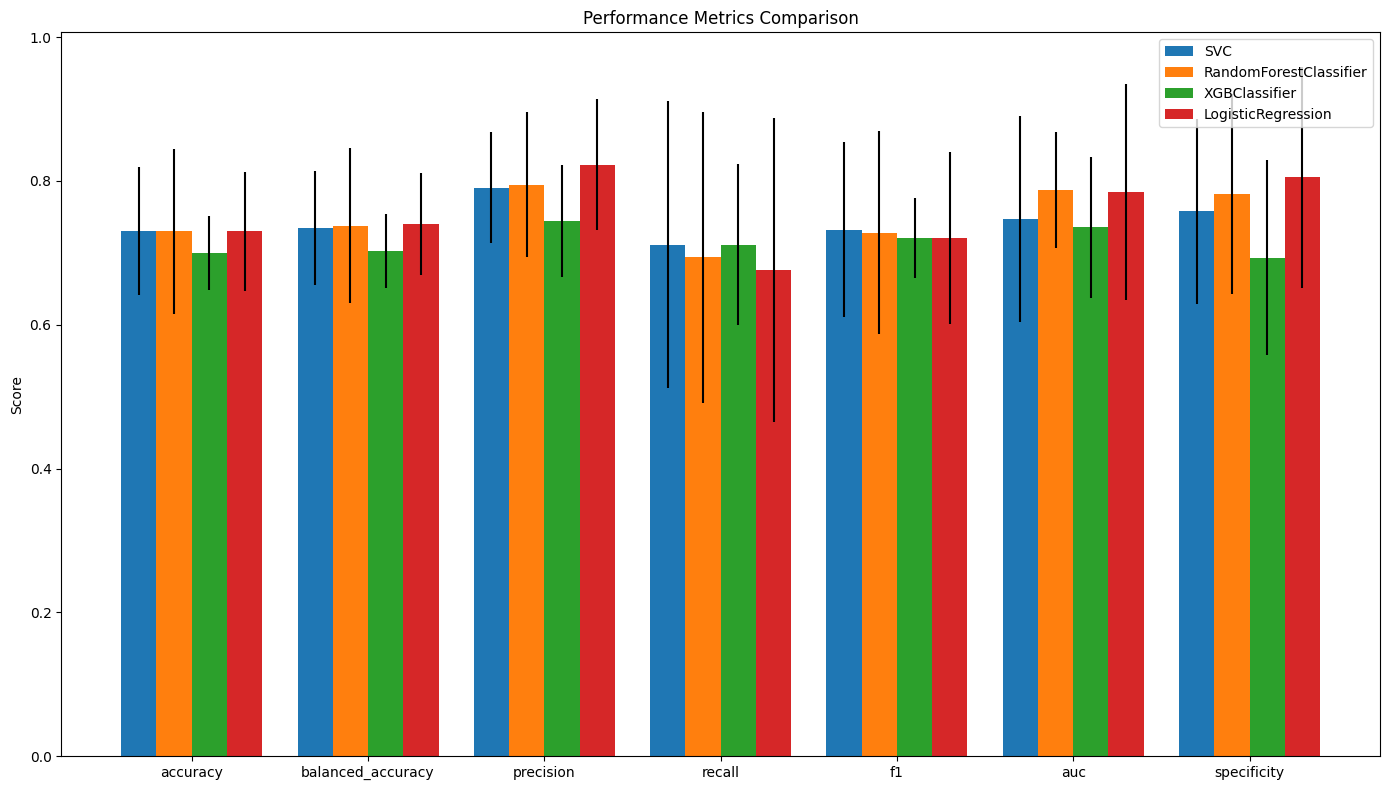

,accuracy,balanced_accuracy,precision,recall,f1,auc,specificity
model,,,,,,,
LogisticRegression,0.73,0.740374,0.822669,0.675824,0.720711,0.784507,0.804924
RandomForestClassifier,0.73,0.737939,0.794690,0.693681,0.728241,0.787265,0.782197
SVC,0.73,0.734557,0.790476,0.711538,0.732143,0.747232,0.757576
XGBClassifier,0.70,0.702360,0.744224,0.711538,0.720826,0.735702,0.693182


In [136]:
# Create a visual comparison of models across metrics
plt.figure(figsize=(14, 8))

metrics_to_plot = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']
x = np.arange(len(metrics_to_plot))
width = 0.2
n_models = len(models)
offsets = np.linspace(-(width * (n_models-1))/2, (width * (n_models-1))/2, n_models)

for i, model_name in enumerate(metrics_comparison.sort_values('f1', ascending=False).index):
    heights = [metrics_comparison.loc[model_name, m] for m in metrics_to_plot]
    errors = [metrics_std.loc[model_name, m] for m in metrics_to_plot]
    plt.bar(x + offsets[i], heights, width, yerr=errors, label=model_name)

plt.xticks(x, metrics_to_plot)
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()
metrics_comparison

,accuracy,balanced_accuracy,precision,recall,f1,auc,specificity
model,,,,,,,
LogisticRegression,0.73,0.740374,0.822669,0.675824,0.720711,0.784507,0.804924
RandomForestClassifier,0.73,0.737939,0.794690,0.693681,0.728241,0.787265,0.782197
SVC,0.73,0.734557,0.790476,0.711538,0.732143,0.747232,0.757576
XGBClassifier,0.70,0.702360,0.744224,0.711538,0.720826,0.735702,0.693182


{0: 43, 1: 55}


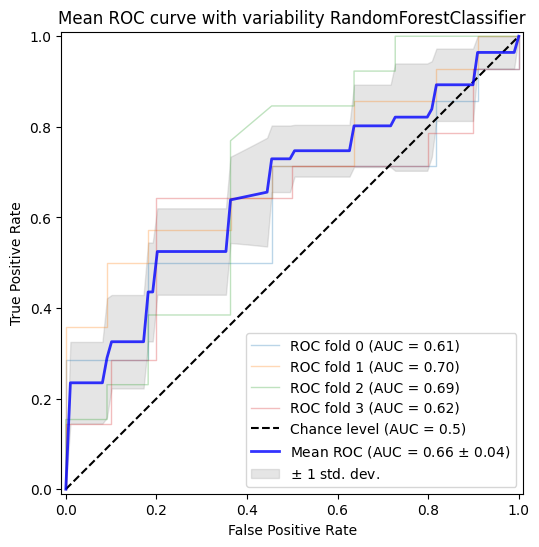

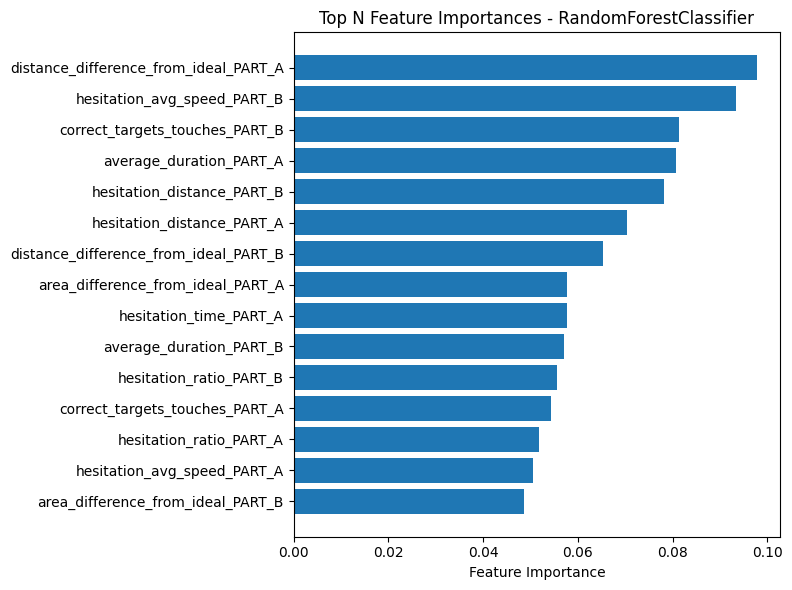

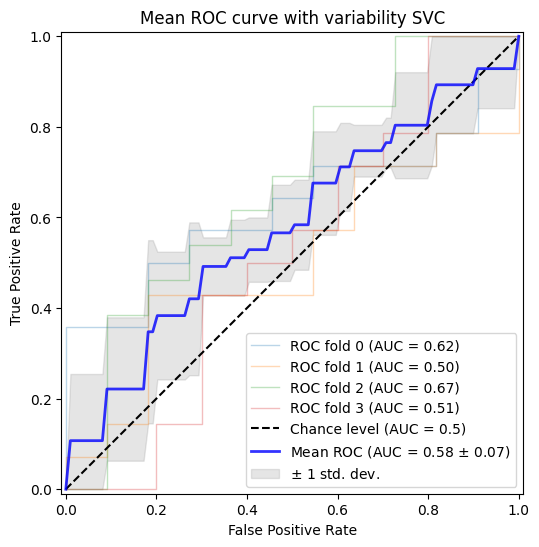

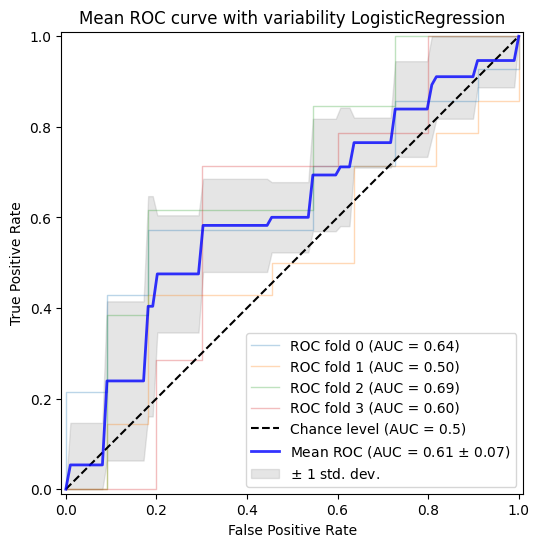

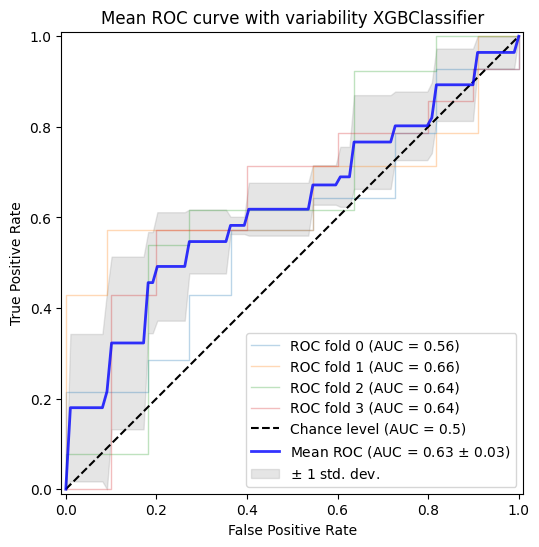

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE

base_model = False

# Features & Target
if base_model:
    demographic_df = df_metadata_cognitive.set_index('suj').copy()
    df_metadata_cognitive['group'] = df_metadata_cognitive.pop('group')
    demographic_df['group'] = demographic_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
    feature_names = demographic_df.columns[:-1]

    X = demographic_df.iloc[:, :-1].values
    y = demographic_df.iloc[:, -1].values
    print(y)
else:
    X = df_digital_tmt_with_target.iloc[:, :-1].values
    y = df_digital_tmt_with_target.iloc[:, -1].values
    feature_names = df_digital_tmt_with_target.columns[:-1]




unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


importances_added = False  # Prevents printing for every fold
n_importances = 15

rfe = RFE(estimator=LogisticRegression(), n_features_to_select=n_importances)


for model in [RandomForestClassifier(n_estimators=1000, random_state=420),
              SVC(kernel='linear', C=1, random_state=42),
              LogisticRegression(max_iter=1000, random_state=42),
              xgb.XGBClassifier(tree_method="hist")]:
    
    model_name = model.__class__.__name__

    steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('rfe', rfe),

    ]


    # # Add SFS only if supported
    # if model_name in ["RandomForestClassifier", "SVC", "LogisticRegression"]:
    #     sfs = SequentialFeatureSelector(
    #         model,
    #         n_features_to_select=10,
    #         direction="forward",
    #         scoring="roc_auc",
    #         cv=4,
    #         n_jobs=-1
    #     )
    #     steps.append(('sfs', sfs))

    # Final step: classifier
    steps.append(('classifier', model))

    pipeline = Pipeline(steps)



    n_splits = 4
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        pipeline.fit(X[train], y[train])

        viz = RocCurveDisplay.from_estimator(
            pipeline,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability {model_name}",
    )
    ax.legend(loc="lower right")
    plt.show()

    # Show feature importances for RandomForest
    if model_name == "RandomForestClassifier" and not importances_added:
        clf = pipeline.named_steps['classifier']
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1][:n_importances]  # Top 10 features

        top_features = feature_names[indices]
        top_importances = importances[indices]

        # Plot
        fig2, ax2 = plt.subplots(figsize=(8, 6))
        ax2.barh(range(len(indices)), top_importances[::-1], align='center')
        ax2.set_yticks(range(len(indices)), top_features[::-1])
        ax2.set_xlabel("Feature Importance")
        ax2.set_title(f"Top N Feature Importances - {model_name}")
        plt.tight_layout()
        plt.show()

        importances_added = True